---
title: "Preprocess NPD summary statistics"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-05-12"
file-modified: "2023-06-23"
abstract: "We read the summary statistics for association of variants with NPD phenotypes 
    in many GWAS and perform some basic filtering to obtain the data matrix for exploring the different methods."

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

# Read

Summary statistics for association of selected SNPs with multiple diseases. SNPs which had significant association with at least one phenotype were selected in a previous preprocessing step, details in [this repository](https://github.com/daklab/npd_sumstats).
Next, the summary statistics of those SNPs for all available phenotypes were included from the respective GWAS.

In [2]:
data_dir = "../data"
studies  = ['gtex', 'pgc', 'ieu']
assoc_file = {}
for s in studies:
    assoc_file[s] = f"{data_dir}/{s}_assoc_sb.txt.gz"
trait_df_filename = f"{data_dir}/trait_meta.csv"

In [3]:
assoc = {}

req_cols = {
    'SNP' : 'string',
    'CHR' : 'string',
    'BP'  : 'Int64', # use Pandas Int64 to handle NA values
    'A1'  : 'string',
    'A2'  : 'string',
    'Z'   : np.float64,
    'P'   : np.float64,
    'BETA': np.float64,
    'SE'  : np.float64,
    'ID'  : 'string',
    'TRAIT': 'string'
}

for s in studies:
    print (f"Read summary statistics for {s}")
    header = pd.read_csv(assoc_file[s], nrows=0, sep='\t')
    use_cols   = [x for x in req_cols.keys() if x in header.columns]
    use_dtypes = {k:v for k, v in req_cols.items() if k in use_cols}
    assoc[s] = pd.read_csv(assoc_file[s], sep = '\t',
                           usecols = use_cols,
                           dtype = use_dtypes
                          )

Read summary statistics for gtex
Read summary statistics for pgc
Read summary statistics for ieu


In [4]:
trait_df = pd.read_csv(trait_df_filename)
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

# Clean

### Combine all summary statistics to a single `DataFrame`.

In [5]:
assoc_df = pd.concat([v for k,v in assoc.items()])
assoc_df['A1'] = assoc_df['A1'].str.upper()
assoc_df['A2'] = assoc_df['A2'].str.upper()
assoc_df['TRAIT'] = assoc_df['TRAIT'].fillna(assoc_df['ID'])

In [6]:
assoc_df = assoc_df.drop_duplicates()

In [7]:
#| code-fold: false

assoc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 680512 entries, 0 to 258531
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     680512 non-null  string 
 1   CHR     664837 non-null  string 
 2   BP      664837 non-null  Int64  
 3   A2      680512 non-null  string 
 4   A1      680512 non-null  string 
 5   Z       260187 non-null  float64
 6   P       680512 non-null  float64
 7   BETA    640083 non-null  float64
 8   SE      640068 non-null  float64
 9   ID      680512 non-null  string 
 10  TRAIT   680512 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 63.0 MB


In [8]:
#| code-fold: false

assoc_df

,SNP,CHR,BP,A2,A1,Z,P,BETA,SE,ID,TRAIT
0,rs147538909,chr1,115746,T,C,-1.197695,0.231036,NaN,NaN,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
1,rs2977608,chr1,832873,C,A,0.205174,0.837436,0.000454,0.002213,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
2,rs9442391,chr1,1048922,C,T,1.415529,0.156913,0.002705,0.001911,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
3,rs6685064,chr1,1275912,T,C,-1.869576,0.061543,-0.007038,0.003764,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
4,rs79113395,chr1,1659060,A,G,-0.462598,0.643653,-0.000987,0.002134,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
...,...,...,...,...,...,...,...,...,...,...,...
258527,rs7599488,2,60718347,T,C,NaN,0.730000,0.000530,0.001563,ieu-b-13,childhood absence epilepsy
258528,rs75010292,2,55172536,G,A,NaN,0.091000,-0.004222,0.002496,ieu-b-13,childhood absence epilepsy
258529,rs10168513,2,55452375,A,G,NaN,0.860000,-0.000413,0.002291,ieu-b-13,childhood absence epilepsy
258530,rs17428810,2,32736043,C,T,NaN,0.840000,-0.000342,0.001684,ieu-b-13,childhood absence epilepsy


In [9]:
print (f"Number of unique SNPs: {len(assoc_df['SNP'].unique())}")
print (f"Number of unique studies: {len(assoc_df['ID'].unique())}")

Number of unique SNPs: 10262
Number of unique studies: 92


### Keep only Biallelic SNPs

`assoc_df_fa`: fa or 'filter_alleles' removes alleles which consists of more than two nucleotides.

In [10]:
def count_nucleotides(row, df):
    '''
    df must have 3 columns: SNP, A1, A2
    '''
    snp = row['SNP']
    snp_dict = df[df['SNP'] == snp][['A1', 'A2']].to_dict('records')
    return len(set([v for x in snp_dict for k, v in x.items()]))


'''
Whether to count the alleles.
If a SNP appears twice, most likely it is biallelic with (A1, A2) and (A2, A1) in the two rows.
However, if the second row has (A2, A3), then it is not biallelic.
Therefore, we count the unique nucleotides for each SNP.

!!! This is slow. I have checked there are no (A2, A3) for the current data. Hence, avoid.
'''
do_count_nucleotides = False

alleles       = assoc_df[['SNP', 'A1', 'A2']].drop_duplicates()
count_colname = 'count'
alleles_count = alleles['SNP'].value_counts().reset_index(name=count_colname)
if do_count_nucleotides:
    count_colname = 'nucleotide_count'
    alleles_count[count_colname] = alleles_count.apply(count_nucleotides, axis = 1, args = (alleles,))
    
biallelic = alleles_count[alleles_count[count_colname] <= 2].merge(alleles, on='SNP', how='inner')

# Arbitrary choice of alleles
one_arrange = biallelic.drop_duplicates('SNP', keep='first').filter(regex = '^(?!.*count)', axis = 1)

In [11]:
assoc_df_allele1 = one_arrange.merge(assoc_df, on=['SNP', 'A1', 'A2'], how='inner')
assoc_df_allele2 = one_arrange.merge(assoc_df, 
                        left_on=['SNP',  'A1', 'A2'], 
                        right_on=['SNP', 'A2', 'A1'],
                        suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
assoc_df_allele2['BETA'] = assoc_df_allele2['BETA'] * -1
assoc_df_allele2['Z']    = assoc_df_allele2['Z'] * -1

assoc_df_fa = pd.concat([assoc_df_allele1, assoc_df_allele2]) # fa: fixed alleles

In [12]:
#| code-fold: false

assoc_df_fa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 677779 entries, 0 to 105160
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     677779 non-null  string 
 1   A1      677779 non-null  string 
 2   A2      677779 non-null  string 
 3   CHR     662150 non-null  string 
 4   BP      662150 non-null  Int64  
 5   Z       259246 non-null  float64
 6   P       677779 non-null  float64
 7   BETA    637545 non-null  float64
 8   SE      637530 non-null  float64
 9   ID      677779 non-null  string 
 10  TRAIT   677779 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 62.7 MB


In [13]:
print (f"Number of unique SNPs: {len(assoc_df_fa['SNP'].unique())}")
print (f"Number of unique studies: {len(assoc_df_fa['ID'].unique())}")

Number of unique SNPs: 10224
Number of unique studies: 92


### Remove SNPs found in fewer studies

SNPs which are available in only a few studies are less powerful 'features'. For a distribution of SNPs, see @fig-hist-snp-distribution. 

In [14]:
snps_count = assoc_df_fa['SNP'].value_counts().reset_index(name='count')

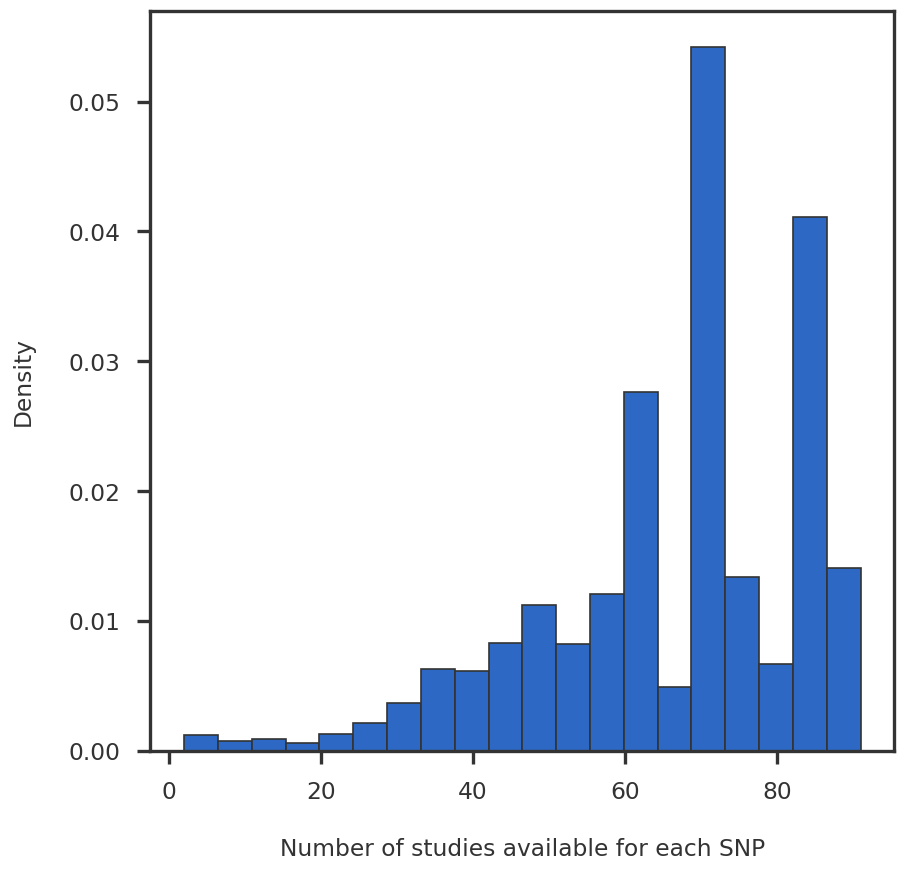

In [15]:
#| label: fig-hist-snp-distribution
#| fig-cap: "Distribution of SNPs in different studies"

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(snps_count['count'], density = True)
ax1.set_xlabel('Number of studies available for each SNP')
ax1.set_ylabel('Density')
plt.show()

In [16]:
assoc_df_fa_nsnp = snps_count[snps_count['count'] >=20 ].merge(assoc_df_fa, on=['SNP'], how='inner').filter(regex = '^(?!.*count)', axis = 1)

In [17]:
#| code-fold: false

assoc_df_fa_nsnp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676261 entries, 0 to 676260
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     676261 non-null  string 
 1   A1      676261 non-null  string 
 2   A2      676261 non-null  string 
 3   CHR     660634 non-null  string 
 4   BP      660634 non-null  Int64  
 5   Z       259054 non-null  float64
 6   P       676261 non-null  float64
 7   BETA    636027 non-null  float64
 8   SE      636012 non-null  float64
 9   ID      676261 non-null  string 
 10  TRAIT   676261 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 57.4 MB


In [18]:
print (f"Number of unique SNPs: {len(assoc_df_fa_nsnp['SNP'].unique())}")
print (f"Number of unique studies: {len(assoc_df_fa_nsnp['ID'].unique())}")

Number of unique SNPs: 10068
Number of unique studies: 92


### Remove duplicate (SNP, ID) combinations

In [19]:
assoc_df_fa_nsnp_nodup = assoc_df_fa_nsnp.drop_duplicates(subset=['SNP', 'ID'], keep = False)

In [20]:
#| code-fold: false

assoc_df_fa_nsnp_nodup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 676229 entries, 0 to 676260
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     676229 non-null  string 
 1   A1      676229 non-null  string 
 2   A2      676229 non-null  string 
 3   CHR     660602 non-null  string 
 4   BP      660602 non-null  Int64  
 5   Z       259054 non-null  float64
 6   P       676229 non-null  float64
 7   BETA    635995 non-null  float64
 8   SE      635980 non-null  float64
 9   ID      676229 non-null  string 
 10  TRAIT   676229 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 62.6 MB


In [21]:
#| code-fold: false

assoc_df_fa_nsnp_nodup

,SNP,A1,A2,CHR,BP,Z,P,BETA,SE,ID,TRAIT
0,rs10486722,C,T,chr7,41772310,0.881222,0.378198,0.001757,0.001994,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
1,rs10486722,C,T,chr7,41772310,1.369354,0.170889,0.003476,0.002538,UKB_1180_Morning_or_evening_person_chronotype,UKB_1180_Morning_or_evening_person_chronotype
2,rs10486722,C,T,chr7,41772310,-0.138782,0.889622,-0.000257,0.001850,UKB_1200_Sleeplessness_or_insomnia,UKB_1200_Sleeplessness_or_insomnia
3,rs10486722,C,T,chr7,41772310,0.442336,0.658246,0.000035,0.000080,UKB_20002_1243_self_reported_psychological_or_...,UKB_20002_1243_self_reported_psychological_or_...
4,rs10486722,C,T,chr7,41772310,0.275442,0.782977,0.000030,0.000110,UKB_20002_1262_self_reported_parkinsons_disease,UKB_20002_1262_self_reported_parkinsons_disease
...,...,...,...,...,...,...,...,...,...,...,...
676256,rs2322,C,G,4,9701603,NaN,0.396100,-0.077600,0.091500,ieu-b-7,Parkinson's disease
676257,rs2322,C,G,4,9701603,NaN,0.107599,0.024041,0.014941,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...
676258,rs2322,C,G,4,9701603,NaN,0.430338,0.016141,0.020468,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...
676259,rs2322,C,G,4,9701603,NaN,0.068770,0.049301,0.027090,MHQ_Single_Depression_WG_MAF1_INFO4_HRC_Only_F...,MHQ_Single_Depression_WG_MAF1_INFO4_HRC_Only_F...


In [22]:
print (f"Number of unique SNPs: {len(assoc_df_fa_nsnp_nodup['SNP'].unique())}")
print (f"Number of unique studies: {len(assoc_df_fa_nsnp_nodup['ID'].unique())}")

Number of unique SNPs: 10068
Number of unique studies: 92


# Data Matrix

In [23]:
beta_df   = assoc_df_fa_nsnp_nodup[['SNP', 'ID', 'BETA']].pivot(index = 'SNP', columns = 'ID', values = 'BETA').rename_axis(None, axis = 0).rename_axis(None, axis = 1)
se_df     = assoc_df_fa_nsnp_nodup[['SNP', 'ID', 'SE']].pivot(index = 'SNP', columns = 'ID', values = 'SE').rename_axis(None, axis = 0).rename_axis(None, axis = 1)
zscore_df = assoc_df_fa_nsnp_nodup[['SNP', 'ID', 'Z']].pivot(index = 'SNP', columns = 'ID', values = 'Z').rename_axis(None, axis = 0).rename_axis(None, axis = 1)

se_df     = se_df.fillna(beta_df / zscore_df).replace(0, np.nan)
zscore_df = zscore_df.fillna(beta_df / se_df)
prec_df   = se_df.apply(lambda x: 1 / x / x)

In [24]:
#| code-fold: false

zscore_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10068 entries, rs1000031 to rs999494
Data columns (total 92 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   AD_sumstats_Jansenetal_2019sept.txt.gz                                                            10020 non-null  float64
 1   CNCR_Insomnia_all                                                                                 9792 non-null   float64
 2   ENIGMA_Intracraneal_Volume                                                                        9706 non-null   float64
 3   GPC-NEO-NEUROTICISM                                                                               9430 non-null   float64
 4   IGAP_Alzheimer                                                                                    9651 non-null   floa

In [25]:
#| code-fold: false

pd.testing.assert_index_equal(beta_df.index, prec_df.index)
pd.testing.assert_index_equal(beta_df.index, zscore_df.index)
pd.testing.assert_index_equal(beta_df.columns, prec_df.columns)
pd.testing.assert_index_equal(beta_df.columns, zscore_df.columns)

### Remove studies with missingness

Studies with high missingness are not good samples, hence they are removed. See histogram of missingness in @fig-missingness


In [26]:
zscore_df

,AD_sumstats_Jansenetal_2019sept.txt.gz,CNCR_Insomnia_all,ENIGMA_Intracraneal_Volume,GPC-NEO-NEUROTICISM,IGAP_Alzheimer,ILAE_Genetic_generalised_epilepsy,Jones_et_al_2016_Chronotype,Jones_et_al_2016_SleepDuration,MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_...,MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUK...,...,ieu-b-7,ieu-b-8,ieu-b-9,ocd_aug2017.txt.gz,pgc-bip2021-BDI.vcf.txt.gz,pgc-bip2021-BDII.vcf.txt.gz,pgc-bip2021-all.vcf.txt.gz,pgc.scz2,pgcAN2.2019-07.vcf.txt.gz,pts_all_freeze2_overall.txt.gz
rs1000031,0.999531,-0.327477,2.184712,1.241557,0.441709,-1.041816,0.163658,-0.163658,0.336654,0.793129,...,0.532189,NaN,NaN,-0.198735,1.057089,-0.269020,1.279776,-0.433158,-1.573766,-1.674269
rs1000269,1.212805,-1.046310,0.001880,0.741814,-1.844296,0.771000,2.673787,1.126391,-0.092067,-0.163246,...,1.665179,-0.732000,-0.699000,0.100883,-0.226381,0.338368,-0.924392,0.832016,0.681645,-0.701776
rs10003281,0.813444,2.034345,-2.023031,-1.750164,-0.076778,1.448634,0.954165,-1.805477,NaN,NaN,...,-0.475795,4.437998,2.366001,0.967399,0.286699,-1.162661,-0.199299,0.014539,NaN,-1.379710
rs10004866,-0.011252,1.327108,1.004786,1.442363,-1.215173,0.139000,0.050154,1.439531,-2.458370,-2.407460,...,-1.234375,-2.520001,-0.593997,-0.685110,0.902252,1.106939,1.776456,-1.654677,-0.964630,0.851608
rs10005235,-0.612540,-0.410609,1.526040,0.653087,0.344062,-1.868000,2.183486,-1.514102,0.460191,0.393006,...,0.387805,-0.345000,-0.960998,0.177317,-1.339598,1.795867,-1.249969,2.349671,0.996305,-0.333356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9989571,-0.028306,-0.208891,1.883150,0.366470,0.821257,0.712000,-0.453762,1.895698,-0.218149,-0.920789,...,-1.231511,-0.820996,0.712000,-2.150176,-0.877410,-1.938969,-2.729983,3.207917,1.469194,-1.293122
rs9991694,0.679790,-1.005571,-1.004740,0.753472,-0.539271,0.368971,-1.674665,2.862736,3.744820,3.583060,...,0.064417,NaN,NaN,-2.884911,-1.000231,0.031860,-1.248222,2.309425,NaN,1.048454
rs9992763,-0.691405,-0.010299,2.067894,-0.140010,-0.419843,1.320000,0.138304,-0.568052,-0.019684,0.194404,...,0.191860,-0.074000,1.030997,-0.228287,-0.051297,0.781766,0.010638,0.456681,-0.503370,-1.435277
rs9993607,1.625392,-0.391585,-0.113291,0.514268,0.027576,-0.512000,-0.150969,0.113039,4.638940,4.631950,...,-0.685106,0.194000,0.240001,-0.790290,-0.876804,-0.577696,-0.785670,-0.062707,0.240834,-0.199740


In [27]:
pd.DataFrame(zscore_df.isnull()).mean(axis=0)

AD_sumstats_Jansenetal_2019sept.txt.gz    0.004768
CNCR_Insomnia_all                         0.027414
ENIGMA_Intracraneal_Volume                0.035956
GPC-NEO-NEUROTICISM                       0.063369
IGAP_Alzheimer                            0.041418
                                            ...   
pgc-bip2021-BDII.vcf.txt.gz               0.064561
pgc-bip2021-all.vcf.txt.gz                0.034764
pgc.scz2                                  0.032380
pgcAN2.2019-07.vcf.txt.gz                 0.100417
pts_all_freeze2_overall.txt.gz            0.007946
Length: 92, dtype: float64

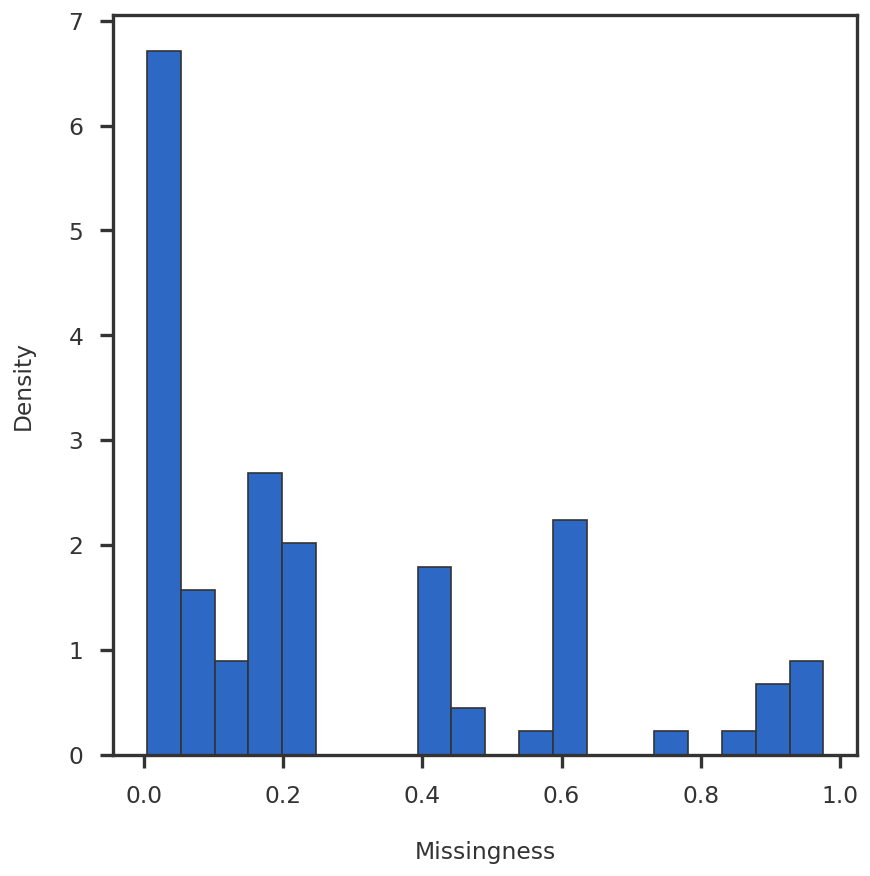

In [28]:
#| label: fig-missingness
#| fig-cap: "Missingness of SNPs in different studies"

missing_df = pd.DataFrame(zscore_df.isnull()).mean(axis = 0).reset_index(name = 'missingness').rename(columns = {'index': 'ID'})

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(missing_df['missingness'], density = True, bins = 20)
ax1.set_xlabel('Missingness')
ax1.set_ylabel('Density')
plt.show()

In [29]:
keep_columns = missing_df[missing_df['missingness'] <= 0.6]['ID'].to_list()
print(f"Keeping {len(keep_columns)} phenotypes with low missingness")

beta_df_sub   = beta_df[keep_columns]
prec_df_sub   = prec_df[keep_columns]
zscore_df_sub = zscore_df[keep_columns]
se_df_sub     = se_df[keep_columns]

remove_columns = [x for x in missing_df['ID'].to_list() if x not in keep_columns]
print("Phenotypes removed:")
for x in remove_columns:
    missingness = missing_df.loc[missing_df['ID'] == x]['missingness'].iloc[0]
    print(f"\t{missingness:.3f}\t{x}\t{phenotype_dict[x]}")

Keeping 80 phenotypes with low missingness
Phenotypes removed:
	0.601	ieu-a-1009	Other psych
	0.602	ieu-a-1018	Other psych
	0.857	ieu-a-1019	BD
	0.609	ieu-a-1062	Cognition
	0.976	ieu-a-298	Neurodegenerative
	0.748	ieu-a-45	Other psych
	0.922	ieu-a-808	BD
	0.930	ieu-a-810	SZ
	0.880	ieu-a-812	Neurodegenerative
	0.963	ieu-a-818	Neurodegenerative
	0.929	ieu-a-824	Neurodegenerative
	0.904	ieu-b-43	Other psych


In [30]:
#| code-fold: false

beta_df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10068 entries, rs1000031 to rs999494
Data columns (total 80 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   AD_sumstats_Jansenetal_2019sept.txt.gz                                                            10020 non-null  float64
 1   CNCR_Insomnia_all                                                                                 8950 non-null   float64
 2   ENIGMA_Intracraneal_Volume                                                                        8351 non-null   float64
 3   GPC-NEO-NEUROTICISM                                                                               3623 non-null   float64
 4   IGAP_Alzheimer                                                                                    8033 non-null   floa

In [31]:
#| code-fold: false

prec_df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10068 entries, rs1000031 to rs999494
Data columns (total 80 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   AD_sumstats_Jansenetal_2019sept.txt.gz                                                            10020 non-null  float64
 1   CNCR_Insomnia_all                                                                                 8950 non-null   float64
 2   ENIGMA_Intracraneal_Volume                                                                        8351 non-null   float64
 3   GPC-NEO-NEUROTICISM                                                                               3623 non-null   float64
 4   IGAP_Alzheimer                                                                                    8033 non-null   floa

# Remove studies with unreliable standard errors

To eliminate unreliable estimates of genetic associations, we remove samples (phenotypes) whose median standard error (SE) of beta value or log odds ratio is more than 0.2. The median SE for all the phenotypes are shown in @fig-se-vs-beta-std

Note: For SE, the mean is not optimal because, in some studies, there are few SNPs with very high (~10000) SE, which inflates the mean.

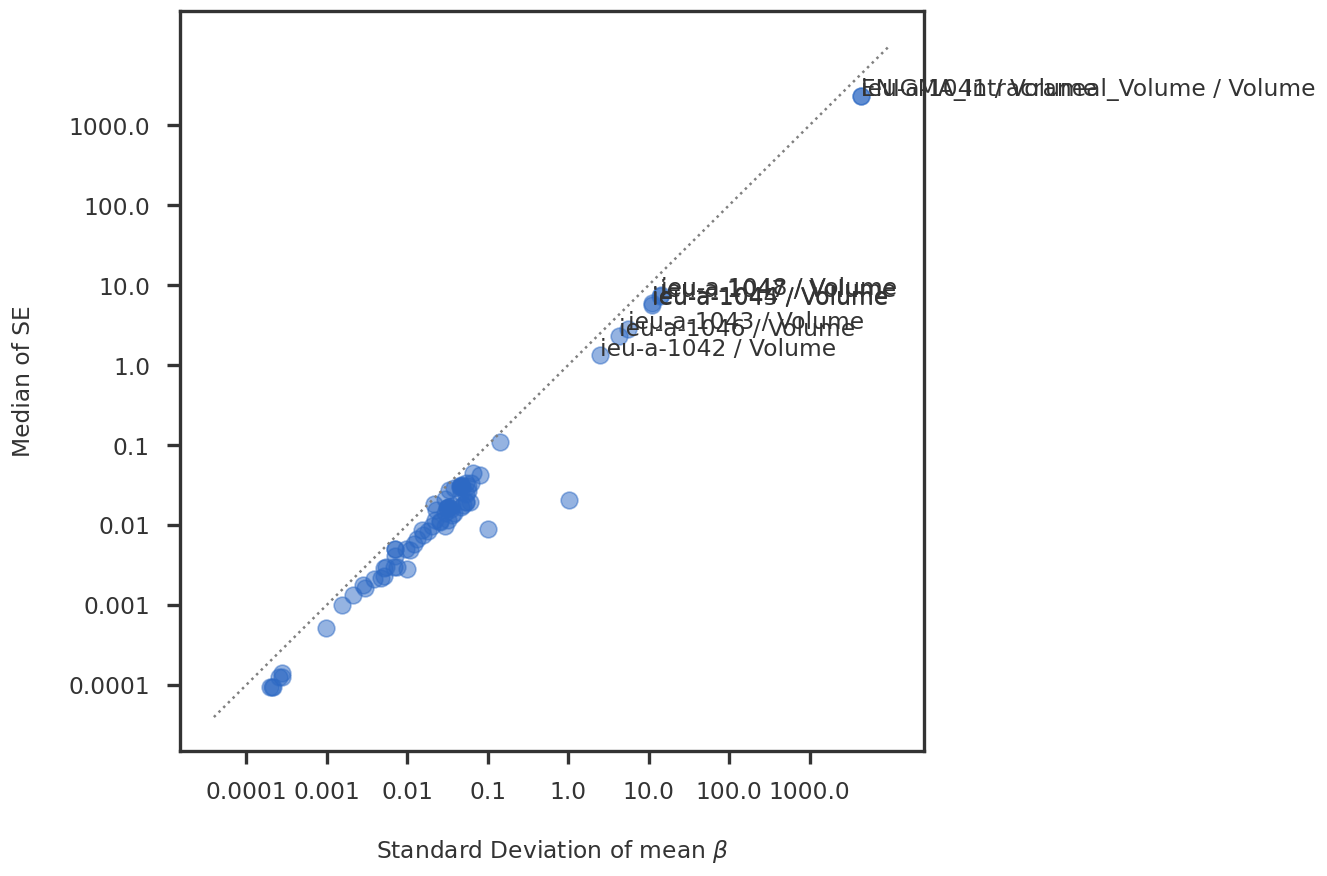

In [32]:
#| label: fig-se-vs-beta-std
#| fig-cap: "Calibration of SE against std of beta"

mean_se  = se_df_sub.median(axis = 0, skipna = True)
mean_se  = pd.DataFrame(mean_se).set_axis(["mean_se"], axis = 1)
beta_std = beta_df_sub.std(axis = 0, skipna = True)
beta_std = pd.DataFrame(beta_std).set_axis(["beta_std"], axis = 1)
error_df = pd.concat([mean_se, beta_std], axis = 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(error_df['beta_std']), np.log10(error_df['mean_se']), alpha = 0.5, s = 100)
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.set_yticks(ax1, scale = 'log10', spacing = 'log10')
mpl_utils.plot_diag(ax1)

keep_columns = error_df.query("mean_se <= 0.2").index
for pid in error_df.index.to_list():
    if pid not in keep_columns:
        pid_text = f"{pid} / {phenotype_dict[pid]}"
        xval = np.log10(error_df.loc[pid]['beta_std'])
        yval = np.log10(error_df.loc[pid]['mean_se'])
        ax1.annotate(pid_text, (xval, yval))

ax1.set_xlabel(r"Standard Deviation of mean $\beta$")
ax1.set_ylabel(r"Median of SE")
plt.show()

In [33]:
print(f"Keeping {len(keep_columns)} phenotypes with low standard error")

beta_df_sub_lowse   = beta_df_sub[keep_columns]
prec_df_sub_lowse   = prec_df_sub[keep_columns]
zscore_df_sub_lowse = zscore_df_sub[keep_columns]
se_df_sub_lowse     = se_df_sub[keep_columns]

remove_columns = [x for x in error_df.index.to_list() if x not in keep_columns]
print("Phenotypes removed:")
for x in remove_columns:
    se = error_df.loc[x]['mean_se']
    bstd = error_df.loc[x]['beta_std']
    print(f"\t{se:.3f}\t{bstd:.3f}\t{x}\t{phenotype_dict[x]}")

Keeping 70 phenotypes with low standard error
Phenotypes removed:
	2322.222	4272.766	ENIGMA_Intracraneal_Volume	Volume
	nan	nan	ILAE_Genetic_generalised_epilepsy	Epilepsy
	2330.240	4287.398	ieu-a-1041	Volume
	1.326	2.479	ieu-a-1042	Volume
	2.855	5.450	ieu-a-1043	Volume
	5.930	11.025	ieu-a-1044	Volume
	5.691	10.837	ieu-a-1045	Volume
	2.319	4.306	ieu-a-1046	Volume
	7.255	13.720	ieu-a-1047	Volume
	7.590	14.253	ieu-a-1048	Volume


# Remove studies with unreliable z-scores

To eliminate unreliable z-scores, we make sure that the median of z-scores is less than 0.2

In [34]:
median_zscore = zscore_df_sub_lowse.median(axis = 0, skipna = True).abs()
median_zscore  = pd.DataFrame(median_zscore).set_axis(["median_zscore"], axis = 1)

keep_columns = median_zscore.query("median_zscore <= 0.2").index
remove_columns = median_zscore.query("median_zscore > 0.2").index

print(f"Keeping {len(keep_columns)} phenotypes with reasonable z-scores.")

beta_df_sub_lowse_zchi2   = beta_df_sub_lowse[keep_columns]
prec_df_sub_lowse_zchi2   = prec_df_sub_lowse[keep_columns]
zscore_df_sub_lowse_zchi2 = zscore_df_sub_lowse[keep_columns]
se_df_sub_lowse_zchi2     = se_df_sub_lowse[keep_columns]

print("Phenotypes removed:")
for x in remove_columns:
    print(f"\t{x}\t{phenotype_dict[x]}")

Keeping 69 phenotypes with reasonable z-scores.
Phenotypes removed:
	ieu-b-5070	SZ


In [35]:
def q1(x, axis = None):
    return np.percentile(x, 25, axis = axis)

def q3(x, axis = None):
    return np.percentile(x, 75, axis = axis)

def iqr_outlier(x, axis = None, bar = 1.5, side = 'both'):
    assert side in ['gt', 'lt', 'both'], 'Side should be `gt`, `lt` or `both`.'

    d_iqr = sc_stats.iqr(x, axis = axis)
    d_q1 = q1(x, axis = axis)
    d_q3 = q3(x, axis = axis)
    iqr_distance = np.multiply(d_iqr, bar)

    stat_shape = list(x.shape)

    if isinstance(axis, collections.abc.Iterable):
        for single_axis in axis:
            stat_shape[single_axis] = 1
    else:
        stat_shape[axis] = 1

    if side in ['gt', 'both']:
        upper_range = d_q3 + iqr_distance
        upper_outlier = np.greater(x - upper_range.reshape(stat_shape), 0)
    if side in ['lt', 'both']:
        lower_range = d_q1 - iqr_distance
        lower_outlier = np.less(x - lower_range.reshape(stat_shape), 0)

    if side == 'gt':
        return upper_outlier
    if side == 'lt':
        return lower_outlier
    if side == 'both':
        return np.logical_or(upper_outlier, lower_outlier)

def get_density(x, data):
    density = sc_stats.gaussian_kde(data)
    return density.pdf(x)

def get_bins(data, nbin, xmin, xmax):
    xdelta = (np.max(data) - np.min(data)) / 10
    if not xmin: xmin = np.min(data) - xdelta
    if not xmax: xmax = np.max(data) + xdelta
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    return xmin, xmax, bins, xbin

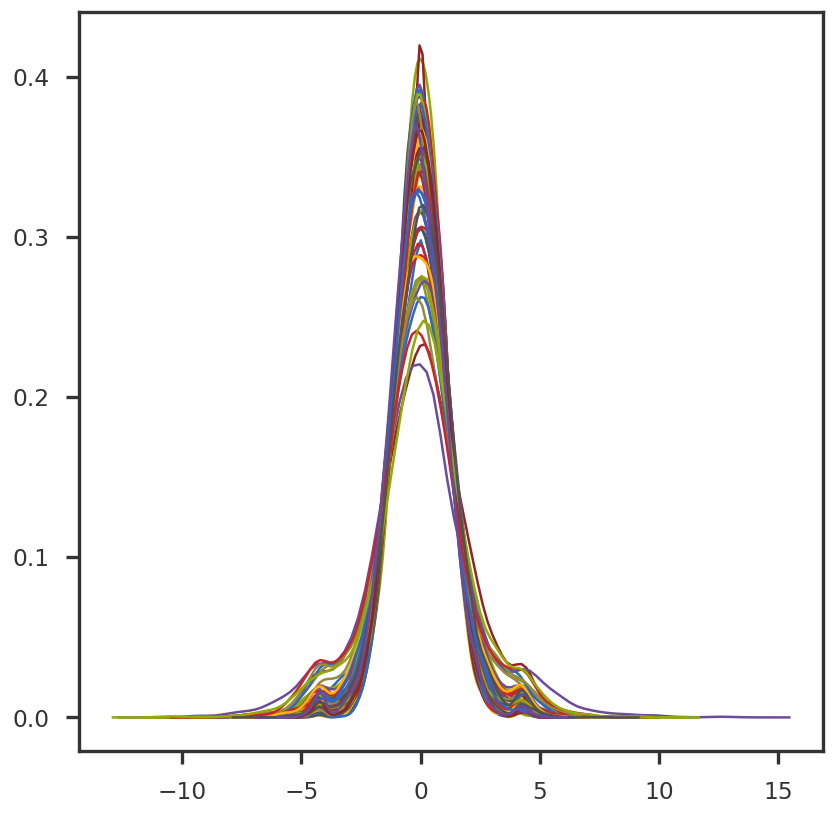

In [36]:
#| label: fig-zscore-distribution
#| fig-cap: "Distribution of z-scores for all phenotypes"

fig = plt.figure()
ax1 = fig.add_subplot(111)

remove_columns = []
for pid in zscore_df_sub_lowse_zchi2.columns.to_list():
    x = zscore_df_sub_lowse_zchi2[pid].values
    x_dropna = x[~np.isnan(x)]
    outlier_mask = iqr_outlier(x_dropna, axis = 0, bar = 5)
    #data = np.square(x_dropna[~outlier_mask])
    data = x_dropna[~outlier_mask]
    xmin, xmax, bins, xbin = get_bins(data, 100, None, None)
    curve = get_density(xbin, data)
    #print (pid, xmax)
    if xmax >= 1000:
        print (pid, xmax)
        remove_columns.append(pid)
    else:
        ax1.plot(xbin, curve, label = pid)
        
#ax1.legend()
plt.show()

# Flip Signs

In [37]:
to_flip = [
    "AD_sumstats_Jansenetal_2019sept.txt.gz",
    "daner_adhd_meta_filtered_NA_iPSYCH23_PGC11_sigPCs_woSEX_2ell6sd_EUR_Neff_70.txt.gz",
    "Jones_et_al_2016_Chronotype",
    "Jones_et_al_2016_SleepDuration",
    "UKB_1160_Sleep_duration",
    #"UKB_1180_Morning_or_evening_person_chronotype",
    "MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz",
    "MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz",
    "PGC3_SCZ_wave3_public.v2.txt.gz",
]

remaining_columns = beta_df_sub_lowse_zchi2.columns.to_list()
for flip_id in to_flip:
    if flip_id in remaining_columns:
        beta_df_sub_lowse_zchi2.loc[:, (flip_id)] = - beta_df_sub_lowse_zchi2[flip_id]
        zscore_df_sub_lowse_zchi2.loc[:, (flip_id)] = - zscore_df_sub_lowse_zchi2[flip_id]
        print(flip_id)

AD_sumstats_Jansenetal_2019sept.txt.gz
daner_adhd_meta_filtered_NA_iPSYCH23_PGC11_sigPCs_woSEX_2ell6sd_EUR_Neff_70.txt.gz
Jones_et_al_2016_Chronotype
Jones_et_al_2016_SleepDuration
UKB_1160_Sleep_duration
MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz
MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz
PGC3_SCZ_wave3_public.v2.txt.gz


# Save Pickle

In [38]:
#| code-fold: false

beta_df_filename = f"{data_dir}/beta_df.pkl"
prec_df_filename = f"{data_dir}/prec_df.pkl"
se_df_filename   = f"{data_dir}/se_df.pkl"
zscore_df_filename = f"{data_dir}/zscore_df.pkl"
beta_df_sub_lowse_zchi2.to_pickle(beta_df_filename)
prec_df_sub_lowse_zchi2.to_pickle(prec_df_filename)
se_df_sub_lowse_zchi2.to_pickle(se_df_filename)
zscore_df_sub_lowse_zchi2.to_pickle(zscore_df_filename)

In [39]:
zscore_df_sub_lowse_zchi2.columns.to_list()

['AD_sumstats_Jansenetal_2019sept.txt.gz',
 'CNCR_Insomnia_all',
 'GPC-NEO-NEUROTICISM',
 'IGAP_Alzheimer',
 'Jones_et_al_2016_Chronotype',
 'Jones_et_al_2016_SleepDuration',
 'MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz',
 'MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz',
 'MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz',
 'MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz',
 'MHQ_Single_Depression_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz',
 'MHQ_Subthreshold_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz',
 'PGC3_SCZ_wave3_public.v2.txt.gz',
 'PGC_ADHD_EUR_2017',
 'PGC_ASD_2017_CEU',
 'SSGAC_Depressive_Symptoms',
 'SSGAC_Education_Years_Pooled',
 'UKB_1160_Sleep_duration',
 'UKB_1180_Morning_or_evening_person_chronotype',
 'UKB_1200_Sleeplessness_or_insomnia',
 'UKB_20002_1243_self_reported_psychological_or_psychiatric

# Save SNP information

In [40]:
assoc_df_fa_nsnp_nodup

,SNP,A1,A2,CHR,BP,Z,P,BETA,SE,ID,TRAIT
0,rs10486722,C,T,chr7,41772310,0.881222,0.378198,0.001757,0.001994,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
1,rs10486722,C,T,chr7,41772310,1.369354,0.170889,0.003476,0.002538,UKB_1180_Morning_or_evening_person_chronotype,UKB_1180_Morning_or_evening_person_chronotype
2,rs10486722,C,T,chr7,41772310,-0.138782,0.889622,-0.000257,0.001850,UKB_1200_Sleeplessness_or_insomnia,UKB_1200_Sleeplessness_or_insomnia
3,rs10486722,C,T,chr7,41772310,0.442336,0.658246,0.000035,0.000080,UKB_20002_1243_self_reported_psychological_or_...,UKB_20002_1243_self_reported_psychological_or_...
4,rs10486722,C,T,chr7,41772310,0.275442,0.782977,0.000030,0.000110,UKB_20002_1262_self_reported_parkinsons_disease,UKB_20002_1262_self_reported_parkinsons_disease
...,...,...,...,...,...,...,...,...,...,...,...
676256,rs2322,C,G,4,9701603,NaN,0.396100,-0.077600,0.091500,ieu-b-7,Parkinson's disease
676257,rs2322,C,G,4,9701603,NaN,0.107599,0.024041,0.014941,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...
676258,rs2322,C,G,4,9701603,NaN,0.430338,0.016141,0.020468,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...
676259,rs2322,C,G,4,9701603,NaN,0.068770,0.049301,0.027090,MHQ_Single_Depression_WG_MAF1_INFO4_HRC_Only_F...,MHQ_Single_Depression_WG_MAF1_INFO4_HRC_Only_F...


In [41]:
all_snp_info = assoc_df_fa_nsnp_nodup[['SNP', 'CHR', 'BP', 'A1', 'A2']].copy()
all_snp_info_nona = all_snp_info.dropna(axis = 0)
all_snp_info_nona.loc[:, 'CHR'] = all_snp_info_nona.CHR.str.replace('chr', '')
all_snp_info_nodup = all_snp_info_nona.drop_duplicates(subset=['SNP'])

In [42]:
all_snp_info_nodup

,SNP,CHR,BP,A1,A2
0,rs10486722,7,41772310,C,T
91,rs2416745,9,120018976,T,G
182,rs9287971,2,174067024,G,A
273,rs12660608,6,123017369,T,C
364,rs1693523,15,52535142,C,T
...,...,...,...,...,...
676161,rs7199470,16,10137879,T,G
676181,rs77337722,18,74935886,T,C
676201,rs183211079,2,151553344,G,A
676221,rs78346960,17,9121155,A,C


In [43]:
snp_info_filename = f"{data_dir}/snp_info.pkl"
all_snp_info_nodup.to_pickle(snp_info_filename)